## Formal Simulated Inference
1. Define F (i.e. your model and assumptions)
2. Formalize test
3. Describe test statistic
4. 
  1. Sample data from $F \in \mathscr{F}_0$
  2. Sample data from $F \in \mathscr{F}_A$
5. 
  1. Plot power vs n (i.e. perspective power analysis)
  2. Plot power vs n (i.e. perspective power analysis)
6. Apply to data
 
### Step 1: Define model and assumptions
###### Model

$G_i, Y_i \sim \mathscr{F}_{G,Y} = \{ F_{G,Y}(\cdot; \theta) : \theta \in \Theta \}$.

Since, all samples observed are graph matched (i.e. nodes are equal across graphs), we can look at just the distribution of adjacency matrices:

$F_{G,Y} = F_{X,Y}$.

Thus,

$X_i = \prod_{u,v}^{\mathcal{E}} A_{uv}$, where $\mathcal{E} \subset V \times V$ <br/>
$Y_i = \{0,1\}$


###### Assumption

$F_{X|0} = ER(p_0) = Bern(p_0)^{V \times V}$ <br/>
$F_{X|1} = ER(p_1) = Bern(p_1)^{V \times V}$

### Step 2: Formalize test

(note: always start as simply as reasonable, but no simpler)

$H_0: p_0 = p_1 $<br/>
$H_A: p_0 \neq p_1$

$\alpha$, the critical value, indicates the power of your null distribution under your test as n \to \infty

### Step 3: Describe test statistic
$\hat{p_i} = \frac{\sum X}{| V \times V |}$


### Intermediate Step

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import os
import csv
import igraph as ig

%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

np.random.seed(123456789)  # for reproducibility, set random seed
alpha = 0.05  # define alpha
r = 20  # define number of rois
N = 100 # number of samples at each iteration

# define number of subjects per class
S = np.array((4, 6, 8, 10, 14, 18, 20, 26, 30, 40,
              50, 60, 70, 80, 100, 120, 150, 200, 250,
              300, 400, 500, 750, 1000, 1500, 2000,
              3000, 5000))

###  Step 4A:  Sample data from null

In [2]:
pow_null = np.array((), dtype=np.dtype('float64'))
# compute this statistic for various sizes of datasets
for s in S:
    s0 = s/2
    s1 = s - s0

    # compute this many times for each operating point to get average
    pval = np.array((), dtype=np.dtype('float64'))    
    for _ in itertools.repeat(None,N):
        g0 = 1 * (np.random.rand( r, r, s0) > 0.5) # (null), 0.52 (classes)
        g1 = 1 * (np.random.rand( r, r, s1) > 0.5) # (null), 0.48 (classes)

        # compute feature of data
        pbar0 = 1.0*np.sum(g0, axis=(0,1))/( r**2 * s0)
        pbar1 = 1.0*np.sum(g1, axis=(0,1))/( r**2 * s1)

        # compute t-test on feature
        pval = np.append(pval, stats.wilcoxon(pbar0, pbar1)[1])
    
    # record average p value at operating point
    pow_null = np.append(pow_null, np.sum(1.0*(pval < alpha))/N)

/usr/local/lib/python2.7/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


###  Step 4B:  Sample data from alternate

In [4]:
pow_alt = np.array((), dtype=np.dtype('float64'))
# compute this statistic for various sizes of datasets
for s in S:
    s0 = s/2
    s1 = s - s0

    # compute this many times for each operating point to get average
    pval = np.array((), dtype=np.dtype('float64'))    
    for _ in itertools.repeat(None,N):
        g0 = 1 * (np.random.rand( r, r, s0) > 0.52) # (null), 0.52 (classes)
        g1 = 1 * (np.random.rand( r, r, s1) > 0.48) # (null), 0.48 (classes)

        # compute feature of data
        pbar0 = 1.0*np.sum(g0, axis=(0,1))/( r**2 * s0)
        pbar1 = 1.0*np.sum(g1, axis=(0,1))/( r**2 * s0)

        # compute t-test on feature
        pval = np.append(pval, stats.wilcoxon(pbar0, pbar1)[1])
    
    # record average p value at operating point
    pow_alt = np.append(pow_alt, np.sum(1.0*(pval < alpha))/N)

### Step 5: Plot power vs n on null set

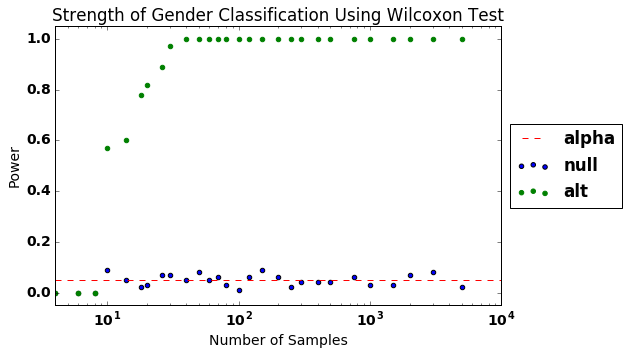

In [27]:
plt.figure(figsize=(8, 5))
plt.scatter(S, pow_null, hold=True, label='null')
plt.scatter(S, pow_alt, color='green', hold=True, label='alt')
plt.xscale('log')
plt.xlabel('Number of Samples')
plt.xlim((0,10000))
plt.ylim((-0.05, 1.05))
plt.ylabel('Power')
plt.title('Strength of Gender Classification Using Wilcoxon Test')
plt.axhline(alpha, color='red', linestyle='--', label='alpha')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../figs/wilcoxon_classification.png')
plt.show()

### Step 6: Apply the above to data

In [22]:
# Initializing dataset names
dnames = list(['../data/desikan/KKI2009'])
print "Dataset: " + ", ".join(dnames)

# Getting graph names
fs = list()
for dd in dnames:
        fs.extend([root+'/'+file for root, dir, files in os.walk(dd) for file in files])
fs = fs[:]

def loadGraphs(filenames, rois, printer=False):
    A = np.zeros((rois, rois, len(filenames)))
    for idx, files in enumerate(filenames):
        if printer:
            print "Loading: " + files
        g = ig.Graph.Read_GraphML(files)
        tempg = g.get_adjacency(attribute='weight')
        A[:,:,idx] = np.asarray(tempg.data)
        
    return A

# Load X
X = loadGraphs(fs, 70)
print X.shape

# Load Y
ys = csv.reader(open('../data/kki42_subjectinformation.csv'))
y = [y[5] for y in ys]
y = y[1:]

Dataset: ../data/desikan/KKI2009
(70, 70, 42)


In [23]:
g_m = np.zeros((70, 70, sum([1 if x=='M' else 0 for x in y])))
g_f = np.zeros((70, 70, sum([1 if x=='F' else 0 for x in y])))

cf=0
cm=0
for idx, val in enumerate(y):
    if val == 'M':
        g_m[:,:,cm] = X[:,:,idx]
        cm += 1
    else:
        g_f[:,:,cf] = X[:,:,idx]
        cf +=1
print g_f.shape
print g_m.shape

(70, 70, 20)
(70, 70, 22)


In [24]:
# compute feature of data
p_f = 1.0*np.sum(1.0*(g_f>0), axis=(0,1))/( 70**2 * 20)
p_m = 1.0*np.sum(1.0*(g_m>0), axis=(0,1))/( 70**2 * 22)

print "Mean p_f: " + str(np.mean(p_f))
print "Mean p_m: " + str(np.mean(p_m))

# compute t-test on feature
pval = stats.wilcoxon(p_m[:20], p_f)[1]
print "P-value: " + str(pval)


Mean p_f: 0.0140418367347
Mean p_m: 0.0131303761174
P-value: 0.0227687437189


### Step 7: Reflect

The result I obtained from my data says that the probability of an edge between men and women is significantly different. I believe that the result is true, as literature has suggested that women have higher connectivity in their brains than men do. However, in order to feel more confident in this answer I would like a larger sample size.